# Suhani's Wrapped
This is my personal project where I explore my Spotify data for the years 2022 to 2023 and try and understand what I can about my own data and song preferences. 

First we import a few packages: 

In [ ]:
import json
import csv
import pandas as pd
import babypandas as bpd
import numpy as np
import matplotlib.pyplot as plt

## File Background Information
I downloaded this information from my Spotify account. For the record this is only the last couple of years because it is not the comprehensive data download. 
As I have been using Spotify since 2018 I anticipate that it will take longer for them to get that information to me. 
'streaming0' contains all the information from the end of the 2022 collection year. This spans from November 30th, 2022 up until October 25th, 2023. <br>
'streaming1' contains everything I have listened to since October 25th, 2023 until December 1st, 2023 which would coincide with the date that this data was delivered to me.

In [ ]:
streaming1 = pd.read_json('Spotify Account Data/StreamingHistory1.json')
streaming1.to_csv('Streaming1.csv')
streaming0 = pd.read_json('Spotify Account Data/StreamingHistory0.json')
streaming0.to_csv('Streaming0.csv')

Below we see the two data frames. The first thing I notice is that 'streaming0' seems to stop at 10,000 rows which I find interesting that it is a rounded number. I do not know if that is a conincidence or a specific choice by Spotify in how they package the 'abridged' data package. 

In [ ]:
streaming0

In [ ]:
streaming1

To make it easier to work with these data frames I am going to combine them into a single data frame that I will call 'streaming' so that it represents the entire listening year for 2023. <br> First I define a list of both the data frame names to contain both years. Then we define the new data frame as the concatenation of the list of data frames stored in 'both_years'. <br> Note: The order of the data frame are listed such that the new data frame remains in chronological order.

In [ ]:
both_years = [streaming0, streaming1]
streaming = pd.concat(both_years)

Now we can see all the songs I have listened to since November 30th, 2022. 

In [ ]:
streaming

## My Listening History with BTS

BTS has been one of my all-time favorite artists consistently over the past few years. The reason I downloaded Spotify at all was to be able to listen to their music while also multi-tasking. <br>
Until I get more data this will just be my initial exploration of what I can do with this information and then we can do a more comprehensive review once I get my extended data package. <br>
I intend to get a better understanding of the amount of time I spend listening to BTS songs. 

First I query out all the times I listened to BTS:

In [ ]:
bts = streaming[streaming['artistName']=='BTS']

The following code determines the number of rows in the bts dataframe which is equivalent to the number of times I have listened to any BTS song. 

In [ ]:
total_bts = bts.shape[0]
print('The number of times I have listened to any BTS song is: ' + str(total_bts))

This line tells me the number of different BTS songs I have listened to.

In [ ]:
num_unique = len(bts['trackName'].unique())
print('Over the last year I have listened to ' + str(num_unique) + ' different BTS songs.')

Now I am curious to determine the number of hours I have spent listening to BTS songs. This can be done by querying out the 'msPlayed' column and converting its sum from milliseconds into hours. <br>
Note: I have created intermediate variables of 'total_s' and 'total_min' in case they become useful later. 

In [ ]:
#First we query out the number of miliseconds played.
total_ms = bts['msPlayed'].sum()

#Then we do the following math to determine how many hours 
total_s = total_ms * 0.001
total_min = total_s / 60
total_hrs = total_min / 60

#I will round to two decimal places.
rounded_total_min = np.round(total_min, 1)
rounded_total_hrs = np.round(total_hrs, 2)

print('I have spent about ' + str(rounded_total_min) + ' minutes listening to BTS in the last year.')
print('This is equivalent to about ' + str(int(np.round(rounded_total_hrs))) + ' hours and 2 minutes of BTS in this time frame.')

Now I want to see the distribution of the BTS songs I listened to. First we are going to group the data frame by each song and count the number of times it was played. I'll assign a new column for the number of times each song is played and create a data frame of just the song counts called 'song_counts'.

In [ ]:
grouped_by_song = bts.groupby('trackName').count()
song_counts = grouped_by_song.assign(timesPlayed = grouped_by_song['endTime'])
song_counts = song_counts.sort_values('timesPlayed', ascending=False)
song_counts = song_counts.get(['timesPlayed']).reset_index()
song_counts

I notice that there are quite a few songs that I only listened to once so I'm going to create a list of song titles that I have only listened to one time. 

In [ ]:
one_listen = song_counts[song_counts.get('timesPlayed') == 1]
one_listen = one_listen['trackName']
num_one_listen = one_listen.shape[0]
print('The number of songs I have listened to only once is ' + str(num_one_listen)+ '.')
print(one_listen)

Now I can transform the information such that we can create a pie chart of the amount of times I have listened to the various BTS songs. <br>
We know that the last 28 songs in our data frame were only listened to one time so we can query out the trackName and timesPlayed series and adjust them to put those 28 songs into a category called 'Other'. 

In [ ]:
num_tracks = song_counts.shape[0]
tracks = song_counts['trackName']
tracks = tracks[:num_tracks-num_one_listen]
tracks = np.append(tracks, 'Other')
print(tracks)
plays = song_counts['timesPlayed']
plays = plays[:num_tracks-num_one_listen]
plays = np.append(plays, num_one_listen)
print(len(plays))

In [ ]:
plt.pie(plays, labels = tracks)
plt.show()

Now I notice that this chart is quite difficult to follow just given the sheer number of songs that are included. So we are going to adjust my strategy to a bar chart instead. 

In [ ]:
tracks
plays

fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(tracks, plays)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.invert_yaxis()

ax.set_title('BTS Songs vs Times Played',
             loc ='left', )

Once again the information is difficult to decipher so let's just focus on my top 20 BTS songs. From this we can determine which BTS song was my favorite in the last year. <br> To do so we can use the information from song_counts but specifically take out the first 20 rows. 

In [ ]:
top_20_BTS = song_counts
top_20_BTS = song_counts.take(np.arange(0, 20))
top_20_BTS

Now we can try plotting out these top 20 songs in a pie chart and see the distribution of my favorite songs. 

In [ ]:
plt.pie(top_20_BTS['timesPlayed'], labels = top_20_BTS['trackName'])
plt.show()

Though we have the pie chart above it is still a bit difficult to visually determine which song is my favorite so let us try using the bar chart again. 

In [ ]:

fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(top_20_BTS['trackName'], top_20_BTS['timesPlayed'])

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.invert_yaxis()

ax.set_title('Top 20 BTS Songs vs Times Played',
             loc ='left', )

From this chart it's clear that my favorite BTS song was 'Black Swan'. This would make sense as this song is part of my studying playlist which I tend to use quite often. Looking through all of the song names I notice that they come from many different albums which made me curious to see how frequently I listen to songs from various albums. 
In order to determine this I believe the best approach is to create a function that will determine which album the song comes from and save that value into a new column in the data frame 'bts'. The best way to do this will be to define a function and apply it to the track names. 

In [ ]:
#I'm curious to see if we can figure out which album is my favorite
#I think I can start by making lists of all the albums and their songs 
#a dictionary might help here where the keys are album names and the values are lists of song titles 
#and then write a function to determine which album each song is 
#apply that function to the track name and then create a new column of just album 

In [ ]:
#BACK LOG OF UNUSED CODE
# def pie_chart_lists(dataframe):
#     output = []
#     track = []
#     #For the purposes of this function we're going to assume the dataframe is in the same format as song_counts
#     tracks = dataframe['trackName']
#     plays = dataframe['timesPlayed']
#     reps = dataframe.shape[0]
#     for i in range(reps): 

In [ ]:
#This is where I will start using the method that was described in the medium article that janine sent me. 


In [ ]:
import ast
from typing import List
from os import listdir
def get_streamings(path: str = 'Spotify Account Data') -> List[dict]:
    
    files = ['Spotify Account Data/' + x for x in listdir(path)
             if x.split('.')[0][:-1] == 'StreamingHistory']
    
    all_streamings = []
    
    for file in files: 
        with open(file, 'r', encoding='UTF-8') as f:
            new_streamings = ast.literal_eval(f.read())
            all_streamings += [streaming for streaming 
                               in new_streamings]
    return all_streamings

In [ ]:

import spotipy.util as util
from spotipy import Spotify as sp
username = 'sm.army'
client_id ='ae3809d4e6814ac4b9f9b96e60a612f7'
client_secret = '533e27ef651d4af499801a3d3fefdd8d'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

In [ ]:
import requests
def get_id(track_name: str, track: str, **artist) -> str:
     headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }
     params = [
    ('q', track_name),
    ('type', 'track'),
    ]
     try:
        response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 5)
        json = response.json()
        first_result = json['tracks']['items'][0]
        track_id = first_result['id']
        return track_id
     except:
        return None

In [ ]:
lucy_id = get_id('Lucy', token, artist='The Beatles')
print(lucy_id)

In [ ]:
import spotipy 
def get_features(track_id: str, token: str) -> dict:
    sp = spotipy.Spotify(auth=token)
    print('testing')
    try:
        features = sp.audio_features([track_id])
        return features[0]
    except:
        return None

In [ ]:
lucy_features = get_features(lucy_id, token)
print(lucy_features)

In [ ]:
streamings = get_streamings()
unique_tracks = list(set([streaming['trackName'] 
                for streaming in streamings]))

all_features = {}
for track in unique_tracks:
    track_id = get_id(track, token)
    features = get_features(track_id, token)
    if features:
        all_features[track] = features
        
with_features = []
for track_name, features in all_features.items():
    with_features.append({'name': track_name, **features})

In [ ]:
import spotipy.util as util
from spotipy import Spotify as sp
username = 'sm.army'
client_id ='ae3809d4e6814ac4b9f9b96e60a612f7'
client_secret = '533e27ef651d4af499801a3d3fefdd8d'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'
my_history = pd.DataFrame(with_features)
# df.to_csv('streaming_history.csv')
# my_history = pd.read_csv('streaming_history.csv')
my_history.columns

In [ ]:
import spotipy.util as util
from spotipy import Spotify
username = 'sm.army'
client_id ='ae3809d4e6814ac4b9f9b96e60a612f7'
client_secret = '533e27ef651d4af499801a3d3fefdd8d'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'

# Obtain an access token using Spotipy util
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)
spotify = Spotify(auth=token)

all_of_bts_URI ='5GDuhKzwN0iBsa84eaxlkw'
# spotify_1 = sp.playlist_tracks(all_of_bts_URI)


# Retrieve tracks from the playlist using the correct method
spotify_1 = spotify.playlist_tracks(all_of_bts_URI)

# Access the 'items' key in the returned dictionary
playlist_tracks = spotify_1['items']
spotify_1

In [ ]:
import pandas as pd
song_df = pd.DataFrame({"URI": [],
                          "Album": [],
                          "Song Name": [],
                          "Artist": [],
                          "Disc Number": [],
                          "Track Number": [],
                          "Popularity": [],
                          "Explicit": [],
                          "Danceability": [],
                          "Energy": [],
                          "Key": [],
                          "Loudness": [],
                          "Mode": [],
                          "Speechiness": [],
                          "Acousticness": [],
                          "Instrumentalness": [],
                          "Liveness": [],
                          "Valence": [],
                          "Tempo": [],
                          "Duration_ms": [],
                          "Time Signature": []})



# idx = 0

# for hundred_songs in [spotify_1]:
#     for i, metadata in enumerate(hundred_songs["items"]):

#         uri = metadata["track"]["uri"].split(":")[2]
#         album = metadata["track"]["album"]["name"]
#         song_name = metadata["track"]["name"]
#         artists = metadata["track"]["artists"]
#         artists_string = ""
#         for artist in artists:
#             artists_string = artists_string + artist['name'] +"; "
#         artists_string = artists_string.strip("; ")

            
        
#         #Popularity of the track
#         track_pop = metadata["track"]["popularity"]
        
#         disc_number = metadata["track"]["disc_number"]
#         track_number = metadata["track"]["track_number"]
        
#         exp = metadata["track"]["explicit"]

#         song = sp.audio_features(uri)[0]
idx = 0
for metadata in playlist_tracks:
    uri = metadata["track"]["uri"].split(":")[2]
    album = metadata["track"]["album"]["name"]
    song_name = metadata["track"]["name"]
    artists = metadata["track"]["artists"]
    artists_string = ""
    for artist in artists:
        artists_string = artists_string + artist['name'] + "; "
    artists_string = artists_string.strip("; ")

    # Popularity of the track
    track_pop = metadata["track"]["popularity"]

    disc_number = metadata["track"]["disc_number"]
    track_number = metadata["track"]["track_number"]

    exp = metadata["track"]["explicit"]

    # Use the correct Spotify object here
    song = spotify.audio_features(uri)[0]
    dan = song['danceability']
    ene = song['energy']
    key = song['key']
    lou = song['loudness']
    mod = song['mode']
    spe = song['speechiness']
    aco = song['acousticness']
    ins = song['instrumentalness']
    liv = song['liveness']
    val = song['valence']
    tem = song['tempo']
    dur = song['duration_ms']
    tim = song['time_signature']

    song_df.loc[idx] = [uri, album, song_name, artists_string, disc_number, track_number, track_pop, exp, 
                               dan, ene, key, lou, mod, spe, aco,
                               ins, liv, val, tem, dur, tim]
    idx += 1

song_df.to_csv('all_BTS')
song_df


In [ ]:
all_BTS_df = song_df

I have now successfully obtained a data frame that contains all the information about the top 84 BTS songs I listend to in the last year. <br> Note: Since the Spotify API gave me a 100 song limit on the number of songs I could use I am only considering their full-Korean albums to make more space. I also determined earlier that I listened to 112 different BTS songs which exceeds the limit given to me. So instead I have queried out songs that I only listened to once in the previous year. My reasoning was that since I only listened to the song one time they have little weight on what my favorite albums are. It is also likely that a fair number of these of these songs were only played one time because they automatically played after a different song that I was listening to. 

Now we can begin to analyze how my favorite songs compare to my favorite albums. 

In [ ]:
mult_plays = song_counts[song_counts['timesPlayed'] != 1]
all_BTS_df

First we group 'all_BTS_df' by the albums. I have reset the index to make sure that I can treat the 'Album' column as a series in the future. 

In [ ]:
grouped_by_album = all_BTS_df.groupby('Album').count().reset_index()
grouped_by_album

Since the count() aggregator just counts the number of matching instances per album we can just look one of these columns. In this case I'll use the URI column to do this and sort in descending order. 

In [ ]:
sorted_grouped_by_album = grouped_by_album.sort_values('URI', ascending=False)[['Album', 'URI']]
sorted_grouped_by_album

Now we can visualize this and compare it with our song information from before.

In [ ]:
albums = sorted_grouped_by_album['Album']
songs_per_album = sorted_grouped_by_album['URI'] 
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(albums, songs_per_album)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.invert_yaxis()

ax.set_title('BTS Albums vs Top Songs per Album',
             loc ='left', )

Based on this visualization we can see that four different albums have the same number of songs that appear in my top BTS songs. To truly determine which of these four albums is my favorite I'm going to create a new data frame called 'top_four_albums' which only contains songs from these albums. Then I will see how many songs in the top 10 of 'song_counts' appear in the corresponding albums. 

In [ ]:
top_10_songs = song_counts.take(np.arange(0,10))
top_10_songs

In [ ]:
song_counts

In [ ]:
top_four_album_names = sorted_grouped_by_album['Album'].take(np.arange(0, 4))
top_four_album_names
top_four_albums = all_BTS_df[all_BTS_df['Album'].isin(top_four_album_names)]
top_four_albums 

I'm now going to merge this with the 'top_four_albums' data frame with the 'song_counts' data frame. And then query out just the 'Album', 'Song Name', and 'Times Played' columns so we can get a better look of the relevant information. <br> Note: For consistency I also renamed the 'timesPlayed' column to 'Times Played'.

In [ ]:
#i just want to see what happens if i merge this with top song counts on the song name column
merged = top_four_albums.merge(song_counts, left_on='Song Name', right_on = 'trackName')
merged = merged.assign(Times_Played = merged['timesPlayed'])
merged = merged.rename(columns={'Times_Played': 'Times Played'})
top_four_albums_w_counts = merged[['Album', 'Song Name', 'Times Played']].sort_values('Times Played', ascending = False)
top_four_albums_w_counts

Now let us try and see how many of my top 10 BTS songs came from which albums. First we take out the top 10 rows, I'll store them in a data frame called 'top_10'.

In [ ]:
top_20 = top_four_albums_w_counts.take(np.arange(0,20))
top_20

Now we group by the album and the song names to organize everything into these groups. 

In [ ]:
grouped_top_20 = top_20.groupby(['Album', 'Song Name']).max()
grouped_top_20 

In [ ]:
import seaborn as sns
grouped_top_20_reset_index  = grouped_top_20.reset_index()

# Sort the DataFrame by 'Times Played' in descending order
grouped_top_20_reset_index_sorted = grouped_top_20_reset_index.sort_values(by='Times Played', ascending=False)

# Plot the barplot with the sorted DataFrame
ax = sns.barplot(x='Song Name', y='Times Played', data=grouped_top_20_reset_index_sorted, hue='Album', dodge=False)

plt.title("My top 10 BTS Songs")
plt.xticks(rotation=90)
plt.ylabel("Number of Times Played")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

And from this I can determine that many of my top songs come from the album "MAP OF THE SOUL: 7". This also implies that this album has been my favorite out of the BTS discography for the past year.

## My Extended Wrapped History <br>

As of December 15th, 2023 I now have access to my extended listening history which goes as far back as my first day of using spotify in 2018. Let's dive in to this data and see what we can learn about how my music tastes have changed over the past few years!

For consistency let us first begin by importing all the necessary packages again. This may be a bit redundant but it's faster than having to scroll all the way back up again. 

In [119]:
import json
import csv
import pandas as pd
import babypandas as bpd
import numpy as np
import matplotlib.pyplot as plt

Now we go through the process of converting each json file into pandas data frames. Though it would be possible for me turn everything into a single data frame in one step I'm making separate data frames in case there comes a time where I want to look at specific years. 

In [120]:
yrs_2018_2020 = pd.read_json('Spotify Extended Streaming History/Streaming_History_Audio_2018-2020_0.json')
yrs_2018_2020 = yrs_2018_2020.drop(['platform', 
                                    'username', 
                                    'ip_addr_decrypted', 
                                    'user_agent_decrypted', 
                                    'offline_timestamp', 
                                    'incognito_mode',
                                    'offline'], axis =1)
yrs_2018_2020


,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2018-04-17T01:11:53Z,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,None,None,None,clickrow,fwdbtn,False,NaN
1,2018-04-17T01:11:59Z,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,None,None,None,fwdbtn,fwdbtn,False,NaN
2,2018-04-17T01:12:08Z,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,None,None,None,fwdbtn,endplay,False,NaN
3,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,None,None,None,clickrow,endplay,False,NaN
4,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,None,None,None,clickrow,endplay,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16149,2020-02-05T05:20:54Z,247733,US,Farewell,Eminem,Music To Be Murdered By,spotify:track:74gykWHknHDrg4eMdcmdRq,None,None,None,clickrow,trackdone,False,NaN
16150,2020-02-05T05:21:16Z,20928,US,No Regrets (feat. Don Toliver),Eminem,Music To Be Murdered By,spotify:track:1lO9CZo6eDrOy0S7khgryG,None,None,None,trackdone,endplay,False,NaN
16151,2020-02-05T05:24:13Z,177693,US,Those Kinda Nights (feat. Ed Sheeran),Eminem,Music To Be Murdered By,spotify:track:0VSzREd1OjEWJ9tXoFHRQH,None,None,None,clickrow,trackdone,False,NaN
16152,2020-02-05T05:24:48Z,22328,US,In Too Deep,Eminem,Music To Be Murdered By,spotify:track:7Dj2wqPYXfSRFwa6qyOztr,None,None,None,trackdone,endplay,False,NaN


In [121]:
yrs_2020_2021 = pd.read_json('Spotify Extended Streaming History/Streaming_History_Audio_2020-2021_1.json')
yrs_2020_2021 = yrs_2020_2021.drop(['platform', 
                                    'username', 
                                    'ip_addr_decrypted', 
                                    'user_agent_decrypted', 
                                    'offline_timestamp', 
                                    'incognito_mode',
                                    'offline'], axis =1)
yrs_2020_2021

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2020-02-05T15:14:17Z,1555,US,None,None,None,None,Ep. 76 - Deathly Hallows Ch. 25 w/ Matt Young,Potterless,spotify:episode:5aY37AWDiqKHLpsQyGWUoD,clickrow,endplay,False,NaN
1,2020-02-05T17:24:26Z,750207,US,None,None,None,None,Ep. 77 - Deathly Hallows Ch. 26 w/ Matt Young,Potterless,spotify:episode:46rjpx5m3y2pH2AwoG3zUv,clickrow,logout,False,NaN
2,2020-02-05T19:30:21Z,228612,US,Outro: Her,BTS,Love Yourself 承 'Her',spotify:track:3l8yQMdniG6Os8gUBNXV57,None,None,None,fwdbtn,trackdone,True,NaN
3,2020-02-05T19:30:21Z,171023,US,Intro : Persona,BTS,MAP OF THE SOUL : PERSONA,spotify:track:2isSdmQfVv32j2haL6hk9x,None,None,None,trackdone,trackdone,True,NaN
4,2020-02-05T19:30:21Z,0,US,Anpanman,BTS,Love Yourself 結 'Answer',spotify:track:01gUlvzAPiwB9Ekq9kGVCM,None,None,None,trackdone,logout,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16298,2021-10-09T05:49:43Z,185277,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,trackdone,False,NaN
16299,2021-10-09T05:52:48Z,185277,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,trackdone,False,NaN
16300,2021-10-09T05:55:54Z,185277,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,trackdone,False,NaN
16301,2021-10-09T15:59:49Z,181771,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,logout,False,NaN


In [122]:
yrs_2021_2022 = pd.read_json('Spotify Extended Streaming History/Streaming_History_Audio_2021-2022_2.json')
yrs_2021_2022 = yrs_2021_2022.drop(['platform', 
                                    'username', 
                                    'ip_addr_decrypted', 
                                    'user_agent_decrypted', 
                                    'offline_timestamp', 
                                    'incognito_mode',
                                    'offline'], axis =1)
yrs_2021_2022

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2021-10-09T16:03:07Z,185277,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,trackdone,False,NaN
1,2021-10-09T19:08:29Z,24370,US,X (with KAROL G),Jonas Brothers,XV,spotify:track:77fvnWALKJR0ws1VUx09CY,None,None,None,trackdone,logout,False,NaN
2,2021-10-09T19:13:09Z,256842,US,Love Again,Dua Lipa,Future Nostalgia,spotify:track:5CSKbHjpqborGnlzagyaDo,None,None,None,clickrow,endplay,False,NaN
3,2021-10-09T19:17:09Z,216053,US,Lonely (feat. ISÁK & Omar Noir),Alan Walker,Different World,spotify:track:6HMT7AzGA5wmn5m2t1BuZR,None,None,None,appload,trackdone,False,NaN
4,2021-10-09T19:20:38Z,208260,US,Let's Shut Up & Dance,Jason Derulo,Let's Shut Up & Dance,spotify:track:05fVrhFBjfElZiDfHDRxhF,None,None,None,trackdone,trackdone,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16074,2022-10-18T01:22:31Z,254653,US,Raanjhanaa,A.R. Rahman,Raanjhanaa (Original Motion Picture Soundtrack),spotify:track:5OMUXgfXsSukZ0zxelpC3b,None,None,None,fwdbtn,trackdone,False,0.0
16075,2022-10-18T01:25:23Z,170342,US,"Main Tera Boyfriend (From ""Raabta"")",Arijit Singh,Groove With Arijit Singh,spotify:track:5VAkPCJTE6tbyReo9J4IQj,None,None,None,trackdone,endplay,False,1.0
16076,2022-10-18T01:30:03Z,280369,US,Lat Lag Gayee,Benny Dayal,Race 2,spotify:track:5XsoDbDt98b0FkFLOhsJuS,None,None,None,clickrow,trackdone,False,0.0
16077,2022-10-18T01:34:00Z,237463,US,Shaam Shaandaar,Amit Trivedi,Shaandaar,spotify:track:46mXuHxCjDiLoLPsqn24P8,None,None,None,trackdone,trackdone,False,0.0


In [123]:
yrs_2022_2023 = pd.read_json('Spotify Extended Streaming History/Streaming_History_Audio_2022-2023_3.json')
yrs_2022_2023 = yrs_2022_2023.drop(['platform', 
                                    'username', 
                                    'ip_addr_decrypted', 
                                    'user_agent_decrypted', 
                                    'offline_timestamp', 
                                    'incognito_mode', 
                                    'offline'], axis =1)
yrs_2022_2023

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2022-10-18T01:40:06Z,238994,US,Sau Tarah Ke,Pritam,Dishoom,spotify:track:54SQet8YMttOgTqDNGcGpe,None,None,None,clickrow,trackdone,False,False
1,2022-10-18T01:43:58Z,230557,US,"Jai Jai Shivshankar (From ""War"")",Vishal-Shekhar,YRF Top 10 - Nightout Sounds,spotify:track:1F3mmE11euAAjwPHCSwSCC,None,None,None,trackdone,trackdone,False,False
2,2022-10-18T01:48:41Z,282012,US,"Tum Hi Ho Bandhu (From ""Cocktail"")",Neeraj Shridhar,Cocktail,spotify:track:2zZTXtLqCsICzEcztKjn47,None,None,None,trackdone,trackdone,False,False
3,2022-10-18T03:17:38Z,164520,US,Where No One Goes,Jónsi,How To Train Your Dragon 2 (Music From The Mot...,spotify:track:47OTksldOYCxAJ7aH3zaxx,None,None,None,trackdone,trackdone,True,False
4,2022-10-18T03:21:13Z,213666,US,"Chopin: Nocturne No. 20 in C-Sharp Minor, Op. ...",Frédéric Chopin,Chopin: Nocturnes,spotify:track:6Yr6Zexsq4VUaDXy5GS9aF,None,None,None,trackdone,trackdone,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15954,2023-12-07T21:38:57Z,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,None,None,None,clickrow,trackdone,False,False
15955,2023-12-07T21:39:08Z,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,None,None,None,trackdone,endplay,False,True
15956,2023-12-07T21:42:14Z,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,None,None,None,clickrow,trackdone,False,False
15957,2023-12-07T21:42:18Z,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,None,None,None,trackdone,logout,False,False


With all of these different data frames we can now combine them into one large data frame containing my entire listerning history on Spotify. 

In [124]:
all_years_ls = [yrs_2018_2020, yrs_2020_2021, yrs_2020_2021, yrs_2021_2022, yrs_2022_2023]
full_history = pd.concat(all_years_ls)
full_history

/Users/suhanisharma/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/suhanisharma/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2018-04-17T01:11:53Z,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,None,None,None,clickrow,fwdbtn,False,NaN
1,2018-04-17T01:11:59Z,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,None,None,None,fwdbtn,fwdbtn,False,NaN
2,2018-04-17T01:12:08Z,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,None,None,None,fwdbtn,endplay,False,NaN
3,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,None,None,None,clickrow,endplay,False,NaN
4,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,None,None,None,clickrow,endplay,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15954,2023-12-07T21:38:57Z,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,None,None,None,clickrow,trackdone,False,False
15955,2023-12-07T21:39:08Z,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,None,None,None,trackdone,endplay,False,True
15956,2023-12-07T21:42:14Z,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,None,None,None,clickrow,trackdone,False,False
15957,2023-12-07T21:42:18Z,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,None,None,None,trackdone,logout,False,False


My first question is how long have I spent using Spotify in the last few years so I'll use the 'ms_played' column to determine that. I'm going to go the nearest hour. <br> Something I have notied is that for each song I listen to it also tracks how much of that song I listened to. For example at the bottom of the data frame I noticed that one song has a value of only 55 'ms_played' which would indicate that I listened to that song for only a few seconds before skipping it. 

In [125]:
millisecs = full_history['ms_played'].sum()
seconds = millisecs / 1000
minutes = seconds / 60
hours = minutes / 60
print('I have spent ' + str(hours) + ' hours using Spotify since 2018.')

I have spent 3571.967826111111 hours using Spotify since 2018.


This number is difficult to conceptualize so let's try converting the number of hours into the number of days. 

In [126]:
days = hours / 24
print('I have spent about ' + str(int(np.round(days))) + ' whole days using Spotify.')
print('This is equivalent to spending about ' + str(np.round(((days/365)*100), 2)) + '% of a year listening to music non-stop.')

I have spent about 149 whole days using Spotify.
This is equivalent to spending about 40.78% of a year listening to music non-stop.


The next thing that I notice is that some of these rows contain information that would indicate it is a podcast episode rather than a song. Let us split this data frame into 'all_music' and 'all_podcast_eps'. 

In [127]:
full_history['episode_show_name'] = full_history['episode_show_name'].astype(str)
all_music = full_history[full_history['episode_show_name'] == 'None']
all_podcast_eps = full_history[full_history['episode_show_name'] != 'None']
all_music

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
0,2018-04-17T01:11:53Z,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,None,None,None,clickrow,fwdbtn,False,NaN
1,2018-04-17T01:11:59Z,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,None,None,None,fwdbtn,fwdbtn,False,NaN
2,2018-04-17T01:12:08Z,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,None,None,None,fwdbtn,endplay,False,NaN
3,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,None,None,None,clickrow,endplay,False,NaN
4,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,None,None,None,clickrow,endplay,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15954,2023-12-07T21:38:57Z,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,None,None,None,clickrow,trackdone,False,False
15955,2023-12-07T21:39:08Z,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,None,None,None,trackdone,endplay,False,True
15956,2023-12-07T21:42:14Z,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,None,None,None,clickrow,trackdone,False,False
15957,2023-12-07T21:42:18Z,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,None,None,None,trackdone,logout,False,False


In [128]:
all_podcast_eps

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped
10560,2019-06-23T16:19:29Z,28252,US,None,None,None,None,Day Two of Trump's U.K. Visit & Why Young Amer...,The Daily Show: Ears Edition,spotify:episode:7HZnNecKoxtLpqyGjfR7qQ,clickrow,logout,False,NaN
12010,2019-09-15T18:18:17Z,792160,US,None,None,None,None,Ep. 0 - Everything I Know Before Reading the B...,Potterless,spotify:episode:6x8HxhJIjCjOnFwDzQtkQh,clickrow,trackdone,False,NaN
12011,2019-09-15T19:41:21Z,3000480,US,None,None,None,None,Ep. 1 - Sorcerer's Stone Ch. 1-8 w/ Alex Moothart,Potterless,spotify:episode:6axizYtyx8IPXa0ZvjHyjC,trackdone,trackdone,False,NaN
12012,2019-09-15T22:30:11Z,1622238,US,None,None,None,None,Ep. 2 - Sorcerer's Stone Ch. 9-17 w/ Charlotte...,Potterless,spotify:episode:7ec2WEzLzBpcbxGZcQ6Wku,trackdone,endplay,False,NaN
12045,2019-09-16T00:40:02Z,2180454,US,None,None,None,None,Ep. 2 - Sorcerer's Stone Ch. 9-17 w/ Charlotte...,Potterless,spotify:episode:7ec2WEzLzBpcbxGZcQ6Wku,clickrow,trackdone,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,2023-05-16T15:28:57Z,150,US,None,None,None,None,Transportation,Distractible,spotify:episode:0khBLR15TmXtfzwhePbn70,trackdone,trackdone,False,False
7372,2023-05-16T15:29:24Z,24296,US,None,None,None,None,Camping,Distractible,spotify:episode:4s423Ody378ElbZq84ib7o,trackdone,endplay,False,True
7409,2023-05-17T19:19:37Z,273147,US,None,None,None,None,Fake Tech,Distractible,spotify:episode:05Mx3DX8Ji1gIlY4Yt6BnO,clickrow,endplay,False,True
7578,2023-05-23T00:32:15Z,231176,US,None,None,None,None,Fake Tech,Distractible,spotify:episode:05Mx3DX8Ji1gIlY4Yt6BnO,clickrow,trackdone,False,False


From here we can adjust each data frame to only include the relavant columns for each type of media. For example we can remove columns for the episode name in 'all_songs' and we can remove information pertaining to artist and track names in 'all_podcast_eps'. 

In [129]:
all_music.columns

Index(['ts', 'ms_played', 'conn_country', 'master_metadata_track_name',
       'master_metadata_album_artist_name', 'master_metadata_album_album_name',
       'spotify_track_uri', 'episode_name', 'episode_show_name',
       'spotify_episode_uri', 'reason_start', 'reason_end', 'shuffle',
       'skipped'],
      dtype='object')

I notice that the columns do not appear to exist even though I can physically see them in the data frame. So I need to start poking around ot see what is causing this issue. 

In [130]:
all_music
print(all_music['episode_name'])
print(all_music['episode_show_name'])
print(all_music['spotify_episode_uri'])
print(all_music.head())

0        None
1        None
2        None
3        None
4        None
         ... 
15954    None
15955    None
15956    None
15957    None
15958    None
Name: episode_name, Length: 79489, dtype: object
0        None
1        None
2        None
3        None
4        None
         ... 
15954    None
15955    None
15956    None
15957    None
15958    None
Name: episode_show_name, Length: 79489, dtype: object
0        None
1        None
2        None
3        None
4        None
         ... 
15954    None
15955    None
15956    None
15957    None
15958    None
Name: spotify_episode_uri, Length: 79489, dtype: object
                     ts  ms_played conn_country master_metadata_track_name  \
0  2018-04-17T01:11:53Z       3250           US                      Power   
1  2018-04-17T01:11:59Z       5503           US                Me Like Yuh   
2  2018-04-17T01:12:08Z       8962           US                      RUMOR   
3  2018-04-17T01:12:12Z       3854           US                   M

When I print out the data frame info I notice that almost every column is in the form of an object which is most likely the issue. <br>
 So before we can drop these columns we need to convert them to a strings. For the time being I'm only going to do this for the columns I intend to drop. 

In [131]:
print(all_music.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79489 entries, 0 to 15958
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ts                                 79489 non-null  object
 1   ms_played                          79489 non-null  int64 
 2   conn_country                       79489 non-null  object
 3   master_metadata_track_name         79411 non-null  object
 4   master_metadata_album_artist_name  79411 non-null  object
 5   master_metadata_album_album_name   79411 non-null  object
 6   spotify_track_uri                  79411 non-null  object
 7   episode_name                       0 non-null      object
 8   episode_show_name                  79489 non-null  object
 9   spotify_episode_uri                0 non-null      object
 10  reason_start                       79489 non-null  object
 11  reason_end                         79489 non-null  object
 12  shuf

In [132]:
columns_to_convert = ['episode_name', 'episode_show_name', 'spotify_episode_uri']
all_music[columns_to_convert] = all_music[columns_to_convert].astype(str)

/var/folders/ks/ytgd9mxn3d9clgmcf4zcxp1m0000gn/T/ipykernel_83876/3266359774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_music[columns_to_convert] = all_music[columns_to_convert].astype(str)


In [133]:
all_music = all_music.drop(['episode_name', 
                            'episode_show_name', 
                            'spotify_episode_uri'], axis=1)
all_music

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped
0,2018-04-17T01:11:53Z,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,clickrow,fwdbtn,False,NaN
1,2018-04-17T01:11:59Z,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,fwdbtn,fwdbtn,False,NaN
2,2018-04-17T01:12:08Z,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,fwdbtn,endplay,False,NaN
3,2018-04-17T01:12:12Z,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,clickrow,endplay,False,NaN
4,2018-04-17T01:12:31Z,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,clickrow,endplay,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15954,2023-12-07T21:38:57Z,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,clickrow,trackdone,False,False
15955,2023-12-07T21:39:08Z,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,trackdone,endplay,False,True
15956,2023-12-07T21:42:14Z,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,clickrow,trackdone,False,False
15957,2023-12-07T21:42:18Z,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,trackdone,logout,False,False


Now that I have separated my music history from my podcast history I am able to do more individual analysis on each. <br>
In order to do analysis on each year let us create a new column called year and transform the time stamp column.

In [145]:
#First I'm going to confirm the data type of the timestamp column
print(type(all_music['ts'].iloc[0]))
#The data type is a string therefore my function can be adjusted accordingly 
def timestamp_to_year(ts):
    #all the time stamps are in the following format: YYYY-MM-DDTHH:MM:SSZ
    #the first half of the stamp is the date and the second half is the time 
    #so first we can split this string on the character 'T'
    split_stamp = ts.split('T')
    #we know the date is the first item in the split_stamp list so i can pull that out
    date = split_stamp[0]
    #now we split this string on the dashes 
    split_date = date.split('-')
    #I'm going to typecast to an int for consistency
    return int(split_date[0])
year_column = all_music['ts'].apply(timestamp_to_year)
all_music = all_music.assign(year = year_column)
front_column = all_music.pop('year')
all_music.insert(1, 'year', front_column)
all_music

<class 'str'>


/Users/suhanisharma/anaconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/Users/suhanisharma/anaconda3/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,ts,year,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped
0,2018-04-17T01:11:53Z,2018,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,clickrow,fwdbtn,False,NaN
1,2018-04-17T01:11:59Z,2018,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,fwdbtn,fwdbtn,False,NaN
2,2018-04-17T01:12:08Z,2018,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,fwdbtn,endplay,False,NaN
3,2018-04-17T01:12:12Z,2018,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,clickrow,endplay,False,NaN
4,2018-04-17T01:12:31Z,2018,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,clickrow,endplay,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15954,2023-12-07T21:38:57Z,2023,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,clickrow,trackdone,False,False
15955,2023-12-07T21:39:08Z,2023,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,trackdone,endplay,False,True
15956,2023-12-07T21:42:14Z,2023,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,clickrow,trackdone,False,False
15957,2023-12-07T21:42:18Z,2023,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,trackdone,logout,False,False


In order to make it easier to access certain columns I'm going to go through the process of renaming some of them. 

In [146]:
all_music = all_music.rename(columns = {'conn_country': 'country', 
                                        'master_metadata_track_name': 'track', 
                                        'master_metadata_album_artist_name': 'artist',
                                        'master_metadata_album_album_name': 'album'
                                        })
all_music

,ts,year,ms_played,country,track,artist,album,spotify_track_uri,reason_start,reason_end,shuffle,skipped
0,2018-04-17T01:11:53Z,2018,3250,US,Power,EXO,THE POWER OF MUSIC – The 4th Album ‘THE WAR’ R...,spotify:track:53YZi9zgTnF0Py0K6ejyWz,clickrow,fwdbtn,False,NaN
1,2018-04-17T01:11:59Z,2018,5503,US,Me Like Yuh,Jay Park,Everything You Wanted,spotify:track:5S5gGOsUarzRXKoaSstwba,fwdbtn,fwdbtn,False,NaN
2,2018-04-17T01:12:08Z,2018,8962,US,RUMOR,KARD,"K.A.R.D Project Vol.3 ""RUMOR""",spotify:track:22iz04Hw1tz0NBpiyoEMT1,fwdbtn,endplay,False,NaN
3,2018-04-17T01:12:12Z,2018,3854,US,MIC Drop,BTS,Love Yourself 承 'Her',spotify:track:2SYa5Lx1uoCvyDIW4oee9b,clickrow,endplay,False,NaN
4,2018-04-17T01:12:31Z,2018,3088,US,DNA,BTS,Love Yourself 承 'Her',spotify:track:5SE57ljOIUJ1ybL9U6CuBH,clickrow,endplay,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15954,2023-12-07T21:38:57Z,2023,167989,US,motive (with Doja Cat),Ariana Grande,Positions,spotify:track:5GkQIP5mWPi4KZLLXeuFTT,clickrow,trackdone,False,False
15955,2023-12-07T21:39:08Z,2023,9440,US,Señorita,Shawn Mendes,Shawn Mendes,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,trackdone,endplay,False,True
15956,2023-12-07T21:42:14Z,2023,185917,US,Houdini,Dua Lipa,Houdini,spotify:track:4OMJGnvZfDvsePyCwRGO7X,clickrow,trackdone,False,False
15957,2023-12-07T21:42:18Z,2023,55,US,Sweet Melody,Little Mix,Confetti,spotify:track:76Tuo484SLohJakHLnGI3B,trackdone,logout,False,False


### My International Music History <br>

Just out of curiosity I want to see how much time I spend listening to music while traveling over the years and the different countries I've been to. <br>
First I have to adjust the data frame to only include countries that are not the United States as that will most likely lead to the biggest outlier. <br>
Then I'll group my listening history based on the year and country. 

In [158]:
non_us = all_music[all_music['country'] != 'US']
grouped_by_country = non_us.groupby(['year', 'country']).sum()
grouped_by_country

/var/folders/ks/ytgd9mxn3d9clgmcf4zcxp1m0000gn/T/ipykernel_83876/4098516487.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_by_country = non_us.groupby(['year', 'country']).sum()


ms_played  shuffle
year country                    
2018 IN        26509418      124
     ZZ         6788024        0
2019 DE         2729157        6
     ZZ         4060551        0
2020 CH         3456519       16
     CZ         3842838       30
     DE         1185845        4
2022 GB         4877118       12
2023 CA         8212915       41

Before I can use this information I'll need to convert the milliseconds column into hours.

In [162]:
grouped_by_country_graph = grouped_by_country.reset_index()
grouped_by_country_graph = grouped_by_country_graph.assign(hours_played = (((grouped_by_country_graph['ms_played'] / 1000) /60)/60))
grouped_by_country_graph

,year,country,ms_played,shuffle,hours_played
0,2018,IN,26509418,124,7.363727
1,2018,ZZ,6788024,0,1.885562
2,2019,DE,2729157,6,0.758099
3,2019,ZZ,4060551,0,1.127931
4,2020,CH,3456519,16,0.960144
5,2020,CZ,3842838,30,1.067455
6,2020,DE,1185845,4,0.329401
7,2022,GB,4877118,12,1.354755
8,2023,CA,8212915,41,2.281365


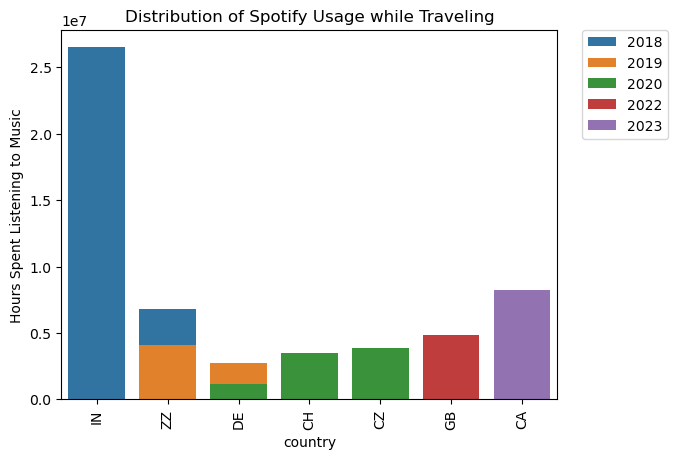

In [164]:
import seaborn as sns
ax = sns.barplot(x='country', y=grouped_by_country_graph['ms_played'], data=grouped_by_country_graph, hue='year', dodge=False)

plt.title("Distribution of Spotify Usage while Traveling")
plt.xticks(rotation=90)
plt.ylabel("Hours Spent Listening to Music")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### Spotify Usage over the Years <br>
We already determiend that I've spent more than more than 3,000 hours using Spotify since I originally installed it. However that information was my overall listening, meaning both music and podcasts. Let's just look at how much time was spent only listening to music over the years. I'm curious to see if there are any trends that can be explained based on when they occur. 

In [170]:
print(all_music['year'])
all_music.groupby('year').sum()['ms_played']

0        2018
1        2018
2        2018
3        2018
4        2018
         ... 
15954    2023
15955    2023
15956    2023
15957    2023
15958    2023
Name: year, Length: 79489, dtype: int64


/var/folders/ks/ytgd9mxn3d9clgmcf4zcxp1m0000gn/T/ipykernel_83876/1623976239.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_music.groupby('year').sum()['ms_played']


year
2018     862038314
2019    1441717877
2020    3185941616
2021    2080788079
2022    2424366697
2023    1850412577
Name: ms_played, dtype: int64

/var/folders/ks/ytgd9mxn3d9clgmcf4zcxp1m0000gn/T/ipykernel_83876/848458873.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = all_music.groupby('year').sum()['ms_played']  # Y-axis points


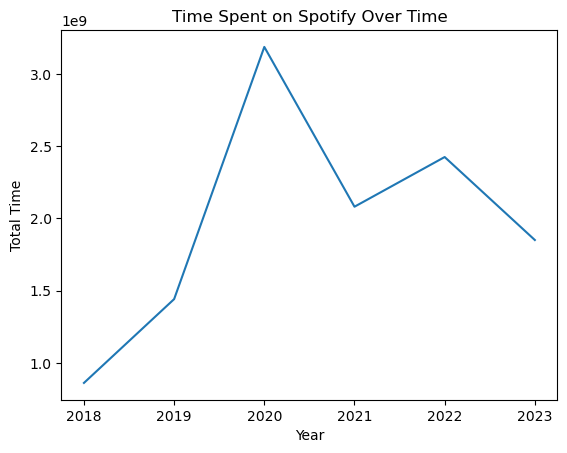

In [172]:
all_music

import matplotlib.pyplot as plt 
import numpy as np 
  
# define data values 
x = all_music['year'].unique()  # X-axis points 
y = all_music.groupby('year').sum()['ms_played']  # Y-axis points 
  


plt.title("Time Spent on Spotify Over Time")
plt.xlabel("Year")
plt.ylabel("Total Time")

plt.plot(x, y)  # Plot the chart 
plt.show() 

From the line plot we can see that my listening time was lowest in 2018 which makes sense given that I did not start using Spotify until April of that year. Then we see that my listneing time reaches a peak at some point between 2019 and 2020. I find it surprising that over 2020 my listening time actually decreased even though it coincides with the pandemic. A potential explanation that I have is that though I was spending a lot more time online I was talking with friends or doing school work rather than listening to music. The time increased again over the next year but seems to have decreased in the last year. The latest decrease in usage is most likely explained by the fact that now when I do not listen to music as much when I do homework and prefer to listen to background noise on YouTube instead. 